# Lab 1: Machine Learning Basics

- Our goal in this lab is to introduce/review the basic "black-box" machine learning paradigm, and use Scikit-Learn to train several simple black box and MLP neural net models for both a regression and classification problem.

- We will additionally use Scikit-Learn for common data preprocessing steps, including test/train split, and feature normalization

- The lab will also introduce basic data loading, cleaning, and merging with the Pandas library.

- We'll finally examine simple error curves for linear and logistic regression, with and without regularization.


In [11]:
## Start by loading necessary libraries
##########

#Load the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#We'll use the geospatial extension to pandas, geopandas for a little bit of the data
#This will be for demonstration purposes only
#!pip install geopandas
#!pip install mapclassify
#!pip install torchvision
#restart kernel
import geopandas as gpd

import mapclassify



## Part 1: Regression: Data Prep, ML Models, and Multilayer Perceptron

Let's begin by loading and merging several relatively simple datasets. We will use county-level data from the US Census (obtained from https://data.census.gov/). Our goal will be to predict our **target/output** variable:

- $y$ = County Per Capita Income

From the following **features/predictors**, for each county:

1. Census Region (categorical variable)
2. Total population
3. County Land Area
4. Population density (derived variable)
5. Birth rate
6. Death rate
7. Net migration rate
8. Educational attainment (divided into several variables representing different education levels)


This data is spread across several files, which we need to load and merge into a common DataFrame. Merging data across datasets using some key is a common data science task, and while not a major focus of this course, it is good to encounter the notion at least once.

Let's load in the following csv file, which gives various demographic characteristics for each county in the US, as a Pandas DataFrame.

Simply run the following cell, **after appropriately changing the file path**, to load our data as a Pandas DataFrame:

In [6]:
#df is a typical generic name for a DataFrame
########

#Change file name/path as appropriate:
f_name = 'C:/dat494labData/co-est2023-alldata.csv'

#Note the encoding for this file is not UTF-8, so we need the optional arguments included:
df = pd.read_csv(f_name, encoding = "ISO-8859-1", engine='python')

#Show the first few entries:
df.head()


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,...,RNATURALCHG2023,RINTERNATIONALMIG2021,RINTERNATIONALMIG2022,RINTERNATIONALMIG2023,RDOMESTICMIG2021,RDOMESTICMIG2022,RDOMESTICMIG2023,RNETMIG2021,RNETMIG2022,RNETMIG2023
0,40,3,6,1,0,Alabama,Alabama,5024294,5031864,5050380,...,-0.306805,0.358254,0.864061,1.057514,5.497784,5.622917,6.038672,5.856038,6.486978,7.096186
1,50,3,6,1,1,Alabama,Autauga County,58809,58915,59203,...,1.549122,0.253983,0.369969,0.566346,4.097597,8.526095,8.178699,4.351581,8.896064,8.745044
2,50,3,6,1,3,Alabama,Baldwin County,231768,233227,239439,...,-0.435967,0.444288,1.028870,1.163912,29.500747,28.956520,27.213932,29.945035,29.985390,28.377843
3,50,3,6,1,5,Alabama,Barbour County,25229,24969,24533,...,-3.368165,0.000000,0.081246,0.527544,-12.645954,9.627689,-1.826113,-12.645954,9.708935,-1.298570
4,50,3,6,1,7,Alabama,Bibb County,22301,22188,22359,...,-2.280294,0.044896,0.045101,0.045606,11.403686,-13.665577,-3.146805,11.448582,-13.620476,-3.101199


#### Construct FIPS as key

Now, for merging in other datasets we'd like a unique identifier for every county: The combination of STATE and COUNTY codes gives this, which we will construct as a five-digit FIPS code, as follows:

In [7]:
#We cast STATE and COUNTY as strings, and then we call the .str.zfill() method to pad to 2 and 3 zeros, respectively:
df['FIPS'] = df['STATE'].astype(str).str.zfill(2) + df['COUNTY'].astype(str).str.zfill(3)

#Check the first few entries of this Series:
df['FIPS'].head()

0    01000
1    01001
2    01003
3    01005
4    01007
Name: FIPS, dtype: object

In [8]:
## Also note the many columns in our DataFrame:
#######

df.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021',
       'POPESTIMATE2022', 'POPESTIMATE2023', 'NPOPCHG2020', 'NPOPCHG2021',
       'NPOPCHG2022', 'NPOPCHG2023', 'BIRTHS2020', 'BIRTHS2021', 'BIRTHS2022',
       'BIRTHS2023', 'DEATHS2020', 'DEATHS2021', 'DEATHS2022', 'DEATHS2023',
       'NATURALCHG2020', 'NATURALCHG2021', 'NATURALCHG2022', 'NATURALCHG2023',
       'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021', 'INTERNATIONALMIG2022',
       'INTERNATIONALMIG2023', 'DOMESTICMIG2020', 'DOMESTICMIG2021',
       'DOMESTICMIG2022', 'DOMESTICMIG2023', 'NETMIG2020', 'NETMIG2021',
       'NETMIG2022', 'NETMIG2023', 'RESIDUAL2020', 'RESIDUAL2021',
       'RESIDUAL2022', 'RESIDUAL2023', 'GQESTIMATESBASE2020',
       'GQESTIMATES2020', 'GQESTIMATES2021', 'GQESTIMATES2022',
       'GQESTIMATES2023', 'RBIRTH2021', 'RBIRTH2022', 'RBIRTH2023',
       'RDEATH2021', 'RDEATH2022', 'RDEATH2023', 'RNATURALCHG20

#### Limit to select columns

Now, let's limit ourselves to the following variables/columns:

- `REGION`
- `FIPS`
- `POPESTIMATE2022`
- `RBIRTH2022` (birth rate)
- `RDEATH2022` (death rate)
- `RNETMIG2022` (rate of net migration)

***Do so in the following cell, and confirm your work by printing out the first few rows.*** Your new DataFrame should still be called `df`.

In [9]:
df = df[['REGION', 'FIPS', 'POPESTIMATE2022', 'RBIRTH2022', 'RDEATH2022', 'RNETMIG2022']]

In [10]:
# Fill in

df = df[['REGION', 'FIPS', 'POPESTIMATE2022', 'RBIRTH2022', 'RDEATH2022', 'RNETMIG2022']]

df.head()

,REGION,FIPS,POPESTIMATE2022,RBIRTH2022,RDEATH2022,RNETMIG2022
0,3,01000,5073903,11.478541,13.276595,6.486978
1,3,01001,59726,11.872630,11.553112,8.896064
2,3,01003,246531,10.333971,12.436982,29.985390
3,3,01005,24700,11.293238,14.746207,9.708935
4,3,01007,21986,10.643816,14.161687,-13.620476


### Add in Educational Attainment, Per Capita Income

Now let's load in some Census data that gives us **educational attainment** for each county...Once again, just run the following cell but change the file path as appropriate.

In [11]:
#Skip the first row, plus indicates the symbols that encode missing values
#Change file path as appropriate

df_ed = pd.read_csv('C://dat494labData//Census_ed_attainment.csv', skiprows=[0],
                    usecols = range(30), na_values=['*****', '(X)'])

In [12]:
## Check the column names this time: Rather messy
df_ed.columns

Index(['Geography', 'Geographic Area Name',
       'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years',
       'Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years',
       'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Less than high school graduate',
       'Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Less than high school graduate',
       'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!High school graduate (includes equivalency)',
       'Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!High school graduate (includes equivalency)',
       'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree',
       'Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree',
       'Estimate!!Total!!AGE B

In [13]:
## So we construct a dictionary for renaming the columns:
###########

rename_dict = {'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over':'Over25_Pop',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than 9th grade':'Ed1',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma':'Ed2',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)':'Ed3',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree':'Ed4',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate\'s degree':'Ed5',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree':'Ed6',
               'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree':'Ed7'}

In [14]:
#And actually rename:
#####

df_ed = df_ed.rename(columns=rename_dict)

In [15]:
#Drop everything not in our renaming dictionary:
#But also keep Geography

#Our list of what to keep
cols_to_keep = list(rename_dict.values()) + ['Geography']

#Difference from all columns is what to drop:
cols_to_drop = list(df_ed.columns.difference(cols_to_keep))


#And drop!
df_ed = df_ed.drop(columns = cols_to_drop)

In [16]:
#Check our results:

df_ed.head()

,Geography,Over25_Pop,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7
0,0500000US01001,40188,694,3163,12517,8440,3495,6726,5153
1,0500000US01003,167022,3350,10681,46391,36169,16046,33474,20911
2,0500000US01005,17675,1289,2866,6507,3516,1397,1167,933
3,0500000US01007,15925,1018,2348,6510,3041,1269,1047,692
4,0500000US01009,40817,2908,4539,14414,8446,4493,3840,2177


In [17]:
## Also confirm the 7 education levels sum to Over25_Pop:
#Can visually confirm quickly like so:
####

pd.DataFrame([df_ed.iloc[:,1], df_ed.iloc[:,2:].sum(axis=1)]).transpose()

,Over25_Pop,Unnamed 0
0,40188,40188
1,167022,167022
2,17675,17675
3,15925,15925
4,40817,40817
...,...,...
3217,39853,39853
3218,6017,6017
3219,15531,15531
3220,22497,22497


In [18]:
## And more rigorously, this should sum to the number of columns in the DataFrame, which is 3222:
((df_ed.iloc[:,1] == df_ed.iloc[:,2:].sum(axis=1))).sum()


3222

In [19]:
## Now that we've confirmed everything adds up, let's convert to *FRACTIONS* of the population with each education level:
#########

df_ed[['Ed1', 'Ed2', 'Ed3', 'Ed4', 'Ed5', 'Ed6', 'Ed7']] = df_ed[['Ed1', 'Ed2', 'Ed3', 'Ed4', 'Ed5', 'Ed6', 'Ed7']].div(df_ed['Over25_Pop'], axis=0)

#Check our work again:
df_ed

,Geography,Over25_Pop,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7
0,0500000US01001,40188,0.017269,0.078705,0.311461,0.210013,0.086966,0.167363,0.128222
1,0500000US01003,167022,0.020057,0.063950,0.277754,0.216552,0.096071,0.200417,0.125199
2,0500000US01005,17675,0.072928,0.162150,0.368147,0.198925,0.079038,0.066025,0.052786
3,0500000US01007,15925,0.063925,0.147441,0.408791,0.190958,0.079686,0.065746,0.043454
4,0500000US01009,40817,0.071245,0.111204,0.353137,0.206924,0.110077,0.094078,0.053336
...,...,...,...,...,...,...,...,...,...
3217,0500000US72145,39853,0.147818,0.084711,0.292400,0.118787,0.105337,0.191654,0.059293
3218,0500000US72147,6017,0.132292,0.144923,0.464185,0.020110,0.093070,0.067475,0.077946
3219,0500000US72149,15531,0.150731,0.060073,0.344086,0.112871,0.116026,0.176550,0.039663
3220,0500000US72151,22497,0.156154,0.096057,0.258879,0.185091,0.119483,0.149398,0.034938


In [20]:
## Over25_Pop is no longer needed, let's drop:
df_ed = df_ed.drop(columns = 'Over25_Pop')
df_ed

,Geography,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7
0,0500000US01001,0.017269,0.078705,0.311461,0.210013,0.086966,0.167363,0.128222
1,0500000US01003,0.020057,0.063950,0.277754,0.216552,0.096071,0.200417,0.125199
2,0500000US01005,0.072928,0.162150,0.368147,0.198925,0.079038,0.066025,0.052786
3,0500000US01007,0.063925,0.147441,0.408791,0.190958,0.079686,0.065746,0.043454
4,0500000US01009,0.071245,0.111204,0.353137,0.206924,0.110077,0.094078,0.053336
...,...,...,...,...,...,...,...,...
3217,0500000US72145,0.147818,0.084711,0.292400,0.118787,0.105337,0.191654,0.059293
3218,0500000US72147,0.132292,0.144923,0.464185,0.020110,0.093070,0.067475,0.077946
3219,0500000US72149,0.150731,0.060073,0.344086,0.112871,0.116026,0.176550,0.039663
3220,0500000US72151,0.156154,0.096057,0.258879,0.185091,0.119483,0.149398,0.034938


In [21]:
### Clean up Geography column:
########

# Last thing: Just keep the last 5 digits of the Geography string = FIPS code
df_ed['FIPS'] = df_ed['Geography'].str[-5:]

df_ed['FIPS']

0       01001
1       01003
2       01005
3       01007
4       01009
        ...  
3217    72145
3218    72147
3219    72149
3220    72151
3221    72153
Name: FIPS, Length: 3222, dtype: object

In [22]:
#And now that we have the cleaned FIPS, drop Geography...
df_ed = df_ed.drop(columns = 'Geography')

df_ed

,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7,FIPS
0,0.017269,0.078705,0.311461,0.210013,0.086966,0.167363,0.128222,01001
1,0.020057,0.063950,0.277754,0.216552,0.096071,0.200417,0.125199,01003
2,0.072928,0.162150,0.368147,0.198925,0.079038,0.066025,0.052786,01005
3,0.063925,0.147441,0.408791,0.190958,0.079686,0.065746,0.043454,01007
4,0.071245,0.111204,0.353137,0.206924,0.110077,0.094078,0.053336,01009
...,...,...,...,...,...,...,...,...
3217,0.147818,0.084711,0.292400,0.118787,0.105337,0.191654,0.059293,72145
3218,0.132292,0.144923,0.464185,0.020110,0.093070,0.067475,0.077946,72147
3219,0.150731,0.060073,0.344086,0.112871,0.116026,0.176550,0.039663,72149
3220,0.156154,0.096057,0.258879,0.185091,0.119483,0.149398,0.034938,72151


#### Phew, Merge the DataFrames!

At last, we can merge our DataFrames. Note that the lists of counties must differ a little, given the different lengths of `df` and `df_ed`, so we'll perform an *inner* join: Only keep entries from each DataFrame that match by key:

In [23]:
#Inner join, using FIPS as key
df_join = df.merge(df_ed, on='FIPS', how='inner')

df_join

,REGION,FIPS,POPESTIMATE2022,RBIRTH2022,RDEATH2022,RNETMIG2022,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7
0,3,01001,59726,11.872630,11.553112,8.896064,0.017269,0.078705,0.311461,0.210013,0.086966,0.167363,0.128222
1,3,01003,246531,10.333971,12.436982,29.985390,0.020057,0.063950,0.277754,0.216552,0.096071,0.200417,0.125199
2,3,01005,24700,11.293238,14.746207,9.708935,0.072928,0.162150,0.368147,0.198925,0.079038,0.066025,0.052786
3,3,01007,21986,10.643816,14.161687,-13.620476,0.063925,0.147441,0.408791,0.190958,0.079686,0.065746,0.043454
4,3,01009,59516,11.686833,14.267043,10.067878,0.071245,0.111204,0.353137,0.206924,0.110077,0.094078,0.053336
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,4,56037,41374,10.626506,10.554217,-6.072289,0.023810,0.045735,0.326520,0.258317,0.145793,0.123686,0.076140
3140,4,56039,23297,8.357853,4.306853,-17.483263,0.023555,0.016785,0.166508,0.167459,0.022772,0.388575,0.214346
3141,4,56041,20727,11.205564,9.804869,1.255796,0.021320,0.035031,0.363191,0.274145,0.115263,0.135302,0.055748
3142,4,56043,7724,9.454122,14.893479,6.475426,0.014309,0.038580,0.284550,0.345590,0.105597,0.132585,0.078790


### Target: Per Capita Income

We need yet another file for county per capita income. As before, we need to load, clean, and merge in the per capita income for each county.

In [24]:
#Change the file path as appropriate once more:
#Simple to load this one:

df_income = pd.read_csv('C://dat494labData//Census_income.csv', skiprows=[0])

In [25]:
#We have something similar to before:
df_income

,Geography,Geographic Area Name,Estimate!!Per capita income in the past 12 months (in 2022 inflation-adjusted dollars),Margin of Error!!Per capita income in the past 12 months (in 2022 inflation-adjusted dollars)
0,0500000US01001,"Autauga County, Alabama",35332,2237
1,0500000US01003,"Baldwin County, Alabama",38907,1145
2,0500000US01005,"Barbour County, Alabama",23378,1659
3,0500000US01007,"Bibb County, Alabama",24966,1765
4,0500000US01009,"Blount County, Alabama",29053,1378
...,...,...,...,...
3217,0500000US72145,"Vega Baja Municipio, Puerto Rico",14818,1515
3218,0500000US72147,"Vieques Municipio, Puerto Rico",9193,1433
3219,0500000US72149,"Villalba Municipio, Puerto Rico",12133,912
3220,0500000US72151,"Yabucoa Municipio, Puerto Rico",11720,772


In [26]:
## Let's rename our columns, clean the geography column and convert to FIPS, and drop everything but FIPS and income:
####

df_income = df_income.rename(columns={'Estimate!!Per capita income in the past 12 months (in 2022 inflation-adjusted dollars)':'Income'})

df_income['FIPS'] = df_income['Geography'].str[-5:]

In [27]:
##Keep only FIPS and Income:
df_income = df_income[['FIPS', 'Income']]
df_income

,FIPS,Income
0,01001,35332
1,01003,38907
2,01005,23378
3,01007,24966
4,01009,29053
...,...,...
3217,72145,14818
3218,72147,9193
3219,72149,12133
3220,72151,11720


In [28]:
## And merge into df_join:
############
df_join = df_join.merge(df_income, on='FIPS', how='inner')

### Finally, merge onto map:

Finally, we will load a **Geo**DataFrame that gives us polygons and the land area for all our counties:

In [29]:
#Be sure you have the geopandas library for this

#Can load directly from the URL:
url_county = 'https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip'
county_gdf = gpd.read_file(url_county)

#This changes the projection (how we go from a 3-dimensional ellipsoid to a 2-D map) to something a little prettier:
county_gdf = county_gdf.to_crs(5070) 

In [30]:
#Make a FIPS Code:
######

county_gdf['FIPS'] = county_gdf['STATEFP'] + county_gdf['COUNTYFP']


In [31]:
#And merge: This time we'll do a LEFT join, so as to keep all counties for visualization purposes:
#It turns out everything matches, so we're good to go!

county_gdf = county_gdf.merge(df_join, on='FIPS', how='inner')

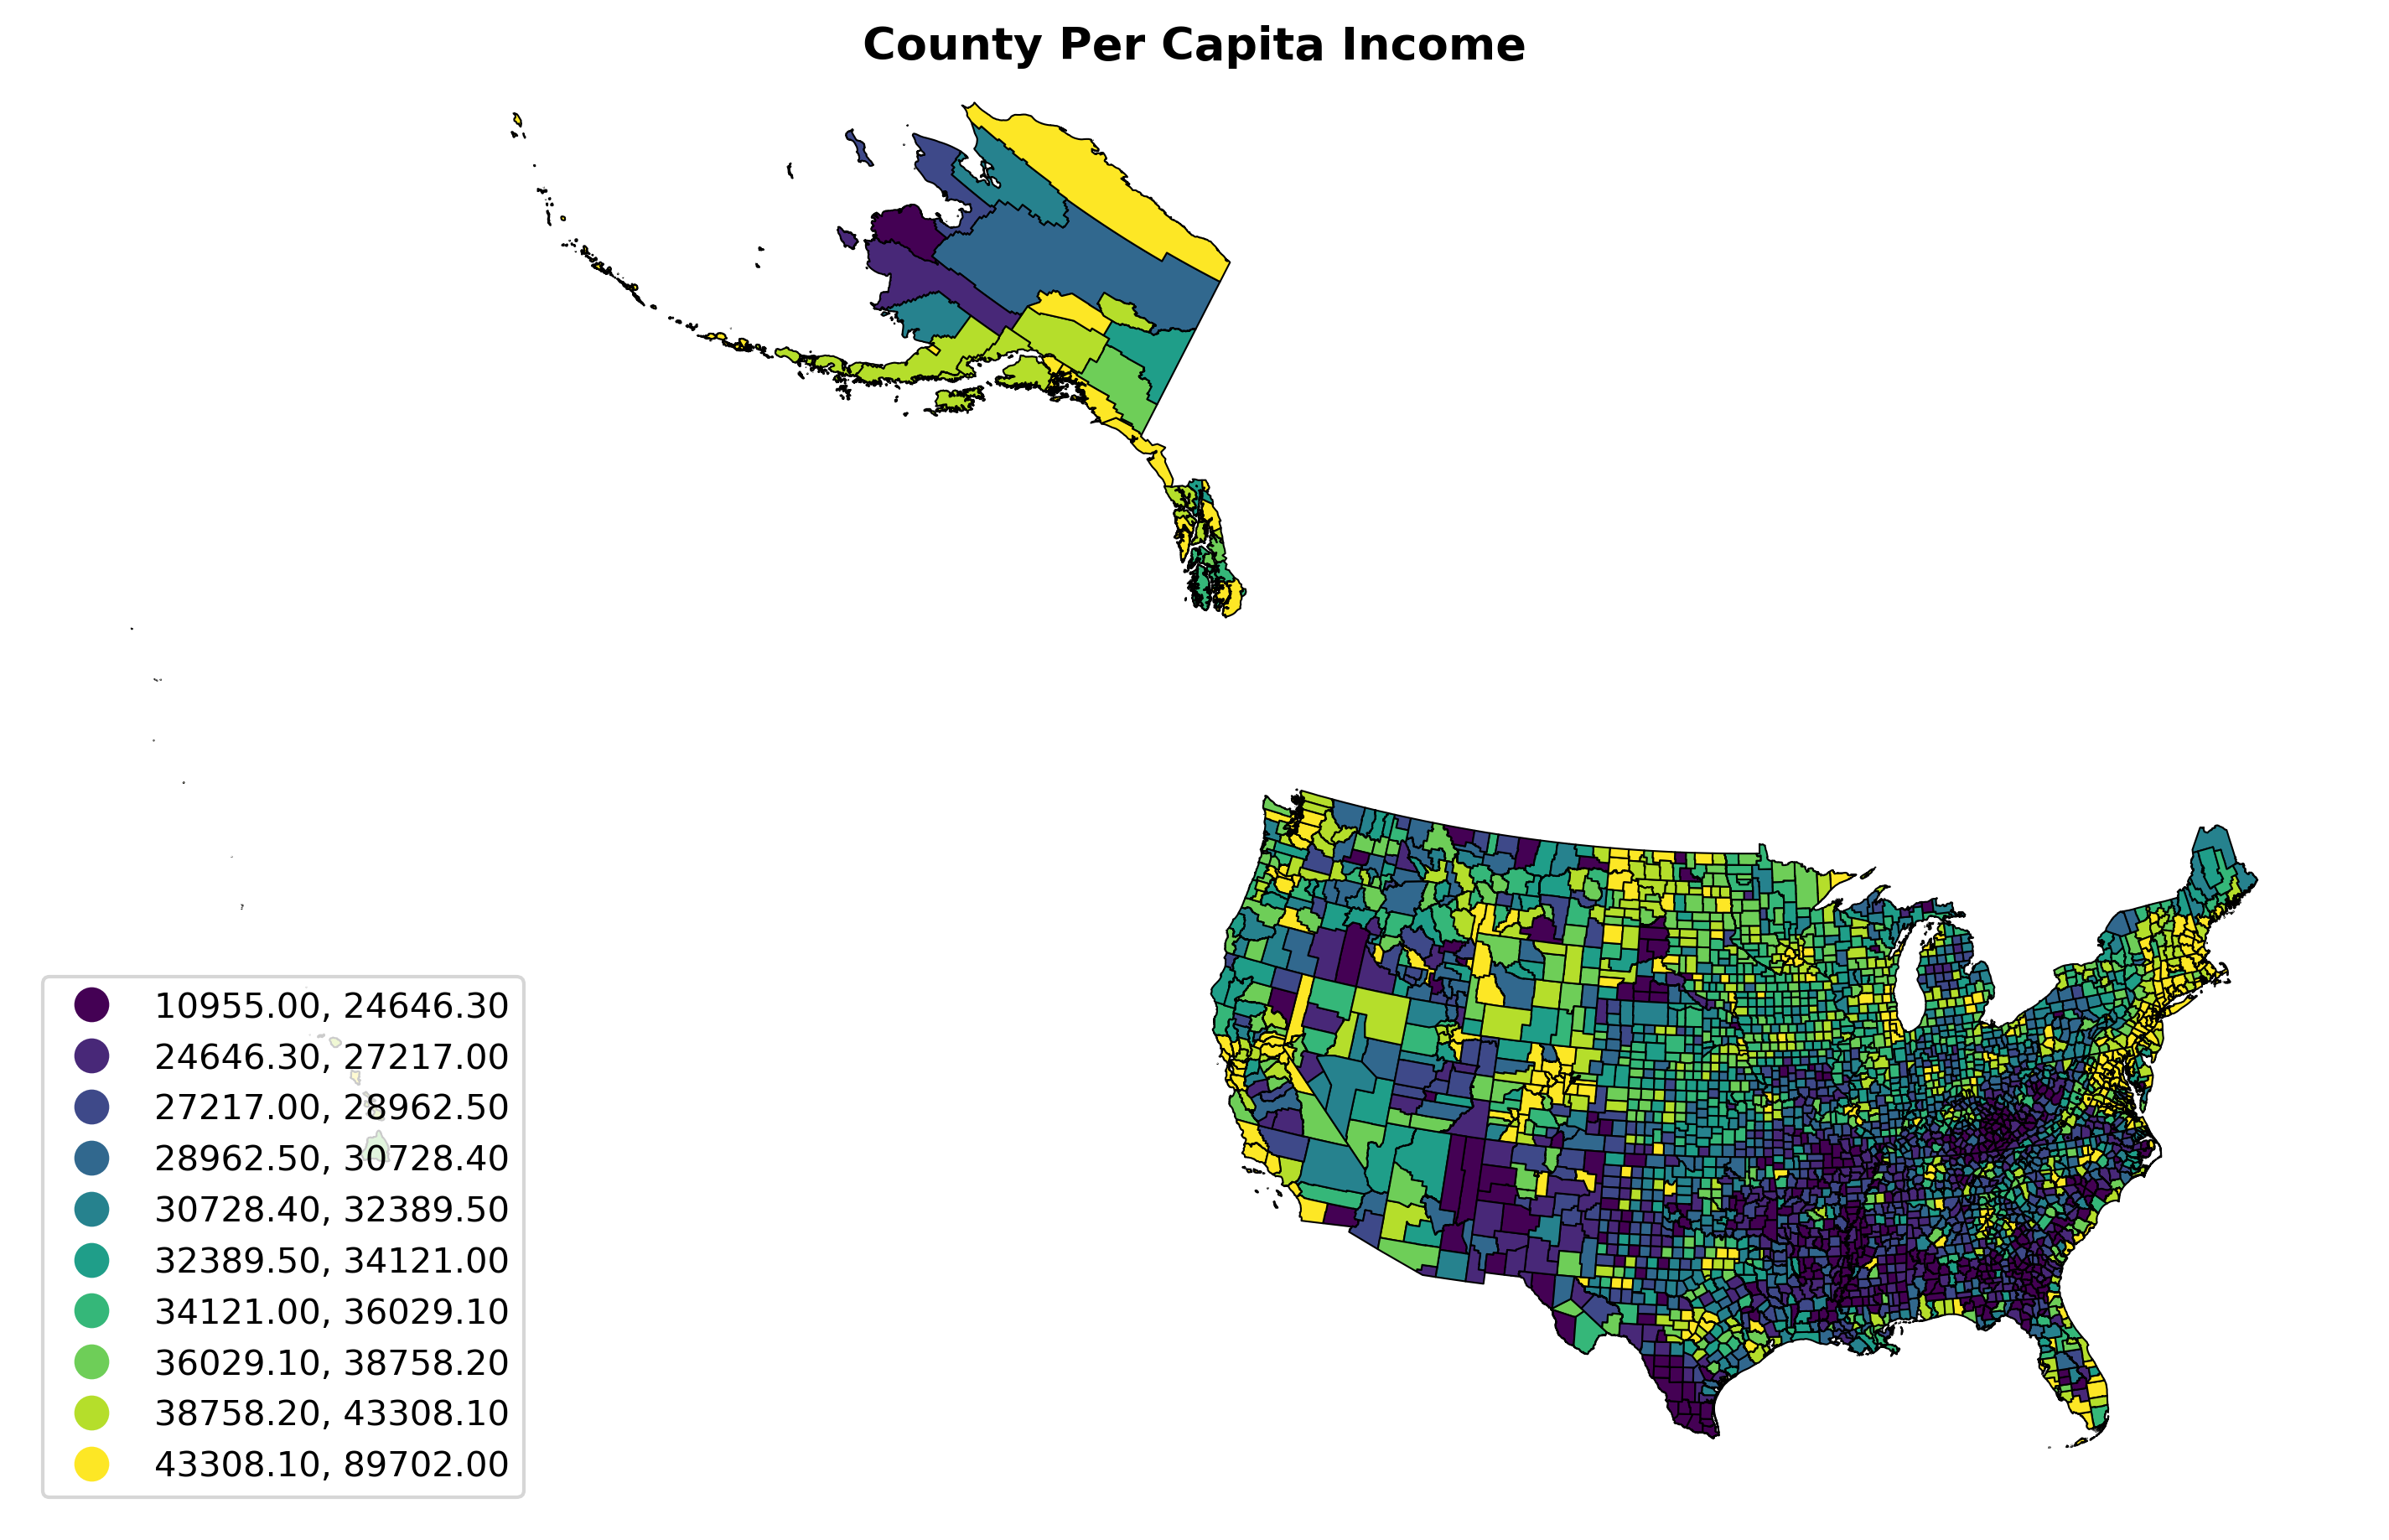

In [32]:
#And plot a nice little map of income:
###########

fig, ax1 = plt.subplots(1, 1, figsize=(12, 12), dpi=300)

county_gdf.plot(column='Income', linewidth=0.5, edgecolor='black', scheme='quantiles', k=10, ax=ax1, legend=True,
        legend_kwds={'loc':'lower left'})

ax1.set_axis_off()
ax1.set_title('County Per Capita Income', fontweight='bold', y=.97, fontsize=13);

### Make DataFrame for Machine Learning

Now let's assemble the columns we want for Machine Learning.

In [33]:
df_ml = county_gdf[['FIPS', 'ALAND', 'REGION', 'POPESTIMATE2022', 'RBIRTH2022',
       'RDEATH2022', 'RNETMIG2022', 'Ed1', 'Ed2', 'Ed3', 'Ed4',
       'Ed5', 'Ed6', 'Ed7', 'Income']]

## Also, we don't want to use FIPS as a feature or a target, but we do want to keep track of which county is which,
## so let's set it to the index:

df_ml = df_ml.set_index('FIPS')

df_ml

,ALAND,REGION,POPESTIMATE2022,RBIRTH2022,RDEATH2022,RNETMIG2022,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7,Income
FIPS,,,,,,,,,,,,,,
01069,1501742235,3,108047,12.054734,14.244816,7.702409,0.036044,0.087806,0.319963,0.234536,0.097050,0.143473,0.081129,32126
01023,2365900083,3,12431,11.289483,17.054326,-3.122623,0.064074,0.112019,0.382236,0.214538,0.096664,0.096443,0.034026,26343
01005,2292160151,3,24700,11.293238,14.746207,9.708935,0.072928,0.162150,0.368147,0.198925,0.079038,0.066025,0.052786,23378
01107,2282835044,3,18749,9.687692,16.485134,13.059652,0.064303,0.086227,0.411124,0.201221,0.092039,0.090421,0.054665,26912
01033,1535742270,3,57993,10.948053,15.410293,10.394597,0.035582,0.100600,0.366352,0.232619,0.084413,0.112110,0.068324,30724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20197,2057320864,2,7009,12.304171,13.448745,7.153588,0.009812,0.024426,0.381837,0.228184,0.104593,0.170564,0.080585,34243
21211,983652108,3,48842,11.536488,10.879606,4.885559,0.039763,0.074723,0.301128,0.185628,0.096617,0.186255,0.115887,37918
27093,1574629006,2,23526,10.995333,10.739628,5.710755,0.015510,0.043642,0.354097,0.229513,0.156923,0.137834,0.062480,37233


## Test/Train Split

- Let's do a *stratified* test-train split
- We want to make sure our data is balanced with respect to Census Region
- Use Scikit-learn's `train_test_split` function to give a stratified split. Do the following:

1. Set the random state to $42$
2. Hold back 20% of the data for testing
3. Stratify based on `REGION` (simply add the optional argument `stratify = df_ml['REGION']`)

Your base input (features, predictors) should be:

`ALAND`, `REGION`, `POPESTIMATE2022`, `RBIRTH2022`,
`RDEATH2022`, `RNETMIG2022`, `Ed1`, `Ed2`,
`Ed3`, `Ed4`, `Ed5`, `Ed6`, `Ed7`

**Additionally: Create the derived variable `pop_dens` by dividing `POPESTIMATE2022` and `ALAND`; include this in your set of input features**

Your output (target) should be:

`Income`

**Create the following variables:**

1. `X_train` (Pandas DataFrame)
2. `X_test` (Pandas DataFrame)
3. `y_train` (Pandas Series)
4. `y_test` (Pandas Series)

**Confirm either numerically or graphically that the splits appear to be balanced with respect to `Division`**. See the example below of balanced training/testing datasets.

In [111]:
from sklearn.model_selection import train_test_split

df_ml['pop_dens'] = df_ml['POPESTIMATE2022'] / df_ml['ALAND']

features = ['ALAND', 'REGION', 'POPESTIMATE2022', 'RBIRTH2022', 'RDEATH2022', 'RNETMIG2022', 
            'Ed1', 'Ed2', 'Ed3', 'Ed4', 'Ed5', 'Ed6', 'Ed7', 'pop_dens']
target = 'Income'

X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_ml['REGION'])

train_region_counts = X_train['REGION'].value_counts(normalize=True)
test_region_counts = X_test['REGION'].value_counts(normalize=True)

In [112]:
print("Training set REGION distribution:")
print(train_region_counts)
print("\nTesting set REGION distribution:")
print(test_region_counts)

Training set REGION distribution:
REGION
3    0.452485
2    0.335586
4    0.142744
1    0.069185
Name: proportion, dtype: float64

Testing set REGION distribution:
REGION
3    0.451510
2    0.335453
4    0.143084
1    0.069952
Name: proportion, dtype: float64


## One-Hot Encode Categorical Variable

Note that our `REGION` feature is categorical. There are three basic ways to handle categorical data:

1. Ordinal encoding: This is only appropriate when there is a natural order to categories. For example, you might map A -> 4, B -> 3, etc. as a GPA coding. This is typically a less-used option.

2. **One-Hot Encoding:** Create a set of dummy variables, $x_i$, each of which can be $0$ or $1$. For any observation $x$,  $x_i$ is $1$ if $x$ is of category $i$, otherwise it is $0$. This is generally the most common method for typical machine learning.

3. Embedding: If there are many possible categories, one-hot encoding embeds the feature in a very high-dimensional space. An alternative is to project the feature onto a lower-dimensional vector space using a matrix with trainable weights. This is typically done for language models: One-hot encoding a vocabulary of, say, 50,000 words is fraught. Instead, it can be embedded in a much lower-dimensional vector space.

Embedding is performed as one-hot encoding followed by matrix multiplication with a trainable weight matrix: This is the projection. It is easy to add an embedding layer with PyTorch, but more on that later!


#### Let's do one-hot encoding:

To recap:

- If $n$ is the number of categories, create $n$ dummy variables, each either $0$ or $1$
- For any observation, only one of these dummy variables will be $1$


This can be done either manually, or, more simply, with Scikit-learn.

**Assuming you performed the test/train split correctly above, you can simply run the following to do the one-hot encoding.**

In [36]:
from sklearn.preprocessing import OneHotEncoder

#We want a dense matrix, not sparse:
cat_encoder = OneHotEncoder(sparse_output = False)

#We'll fit to the training data only: In this case it doesn't matter, but this is best practice
######
cat_encoder.fit(X_train[['REGION']])

#Transform to one-hot encoded version
region_1hot_train = cat_encoder.transform(X_train[['REGION']])

#Check:
region_1hot_train

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [37]:
## We can convert back to a DataFrame:
X_train_region = pd.DataFrame(region_1hot_train,
                         columns = cat_encoder.get_feature_names_out(),
                         index = X_train.index)

X_train_region

,REGION_1,REGION_2,REGION_3,REGION_4
FIPS,,,,
48327,0.0,0.0,1.0,0.0
38055,0.0,1.0,0.0,0.0
48221,0.0,0.0,1.0,0.0
29053,0.0,1.0,0.0,0.0
13153,0.0,0.0,1.0,0.0
...,...,...,...,...
17001,0.0,1.0,0.0,0.0
18057,0.0,1.0,0.0,0.0
12087,0.0,0.0,1.0,0.0


In [38]:
## Merge with original X_train, and drop our old REGION:
## Use the index (FIPS) as the key for merging

X_train = X_train.merge(X_train_region, left_index=True, right_index=True)

X_train = X_train.drop(columns = 'REGION')
X_train

,ALAND,POPESTIMATE2022,RBIRTH2022,RDEATH2022,RNETMIG2022,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7,pop_dens,REGION_1,REGION_2,REGION_3,REGION_4
FIPS,,,,,,,,,,,,,,,,,
48327,2336237980,1979,9.120851,19.255130,15.708133,0.088525,0.132459,0.258361,0.200656,0.081311,0.149508,0.089180,8.470884e-07,0.0,0.0,1.0,0.0
38055,5465546321,9858,9.450739,11.686398,5.894009,0.030594,0.037220,0.321867,0.214155,0.173692,0.182433,0.040039,1.803662e-06,0.0,1.0,0.0,0.0
48221,1089693164,66394,10.437151,15.028274,35.060871,0.026760,0.049555,0.279909,0.251652,0.075610,0.213792,0.102722,6.092908e-05,0.0,0.0,1.0,0.0
29053,1462695259,16763,10.885493,13.457340,8.134215,0.034438,0.061002,0.388423,0.189842,0.092844,0.156529,0.076923,1.146035e-05,0.0,1.0,0.0,0.0
13153,973955122,169775,12.011763,10.029584,13.163088,0.024426,0.045772,0.272292,0.219786,0.117685,0.182920,0.137120,1.743150e-04,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17001,2214826163,64556,10.908810,13.933035,-4.536337,0.015463,0.051077,0.345292,0.221105,0.097816,0.178812,0.090435,2.914721e-05,0.0,1.0,0.0,0.0
18057,1021441615,365463,11.226927,6.524839,17.162622,0.009561,0.018844,0.148096,0.144401,0.071354,0.378018,0.229727,3.577914e-04,0.0,1.0,0.0,0.0
12087,2546044689,81618,8.862413,10.327275,-5.346745,0.035380,0.042338,0.282606,0.192404,0.083944,0.219706,0.143622,3.205678e-05,0.0,0.0,1.0,0.0


In [39]:
## We can do the same procedure with our testing data:
#########

#Use the previously trained/fit cat_encoder:
#Transform to one-hot encoded version
region_1hot_test = cat_encoder.transform(X_test[['REGION']])

## We can convert back to a DataFrame:
X_test_region = pd.DataFrame(region_1hot_test,
                         columns = cat_encoder.get_feature_names_out(),
                         index = X_test.index)

## Merge with original X_test, and drop our old REGION:
## Use the index (FIPS) as the key for merging

X_test = X_test.merge(X_test_region, left_index=True, right_index=True)

X_test = X_test.drop(columns = 'REGION')
X_test

,ALAND,POPESTIMATE2022,RBIRTH2022,RDEATH2022,RNETMIG2022,Ed1,Ed2,Ed3,Ed4,Ed5,Ed6,Ed7,pop_dens,REGION_1,REGION_2,REGION_3,REGION_4
FIPS,,,,,,,,,,,,,,,,,
18105,1021806890,139621,8.070137,8.499019,-3.416763,0.011031,0.042379,0.213909,0.174888,0.075764,0.241233,0.240796,1.366413e-04,0.0,1.0,0.0,0.0
19151,1495047211,7073,10.912698,15.306122,9.778912,0.013546,0.071169,0.377477,0.221391,0.145774,0.130206,0.040437,4.730954e-06,0.0,1.0,0.0,0.0
35053,17214061665,16111,9.382137,13.332510,-6.727980,0.081238,0.071422,0.435075,0.178461,0.066187,0.063569,0.104048,9.359209e-07,0.0,0.0,0.0,1.0
05077,1553493435,8367,9.452354,17.723164,-15.005612,0.043759,0.121104,0.492653,0.207331,0.058130,0.063620,0.013402,5.385926e-06,0.0,0.0,1.0,0.0
39157,1469987547,91971,12.395105,15.082155,-4.106420,0.048315,0.064051,0.448140,0.161040,0.081735,0.131655,0.065064,6.256584e-05,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41019,13042338721,112290,8.679418,18.249948,10.657684,0.025814,0.061523,0.325631,0.298458,0.099611,0.123847,0.065117,8.609652e-06,0.0,0.0,0.0,1.0
29031,1498351220,82931,10.880694,11.486523,10.505080,0.026807,0.054789,0.313921,0.208378,0.059772,0.214857,0.121476,5.534817e-05,0.0,1.0,0.0,0.0
22075,2020676390,22618,12.759101,9.797945,-34.575858,0.074136,0.062938,0.316108,0.279426,0.077354,0.129738,0.060300,1.119328e-05,0.0,0.0,1.0,0.0


## Now Normalize the Data

Now, use Scikit-Learn's standard scaler to standardize both the training and testing data (features only).

Be sure to train the scaler *only* on the training data!

Name the resulting DataFrames `X_train_scaled` and `X_test_scaled`.

In [40]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

##Display data
print("Scaled Training Data:")
print(X_train_scaled.head())

print("\nScaled Testing Data:")
print(X_test_scaled.head())

Scaled Training Data:
      ALAND  POPESTIMATE2022  RBIRTH2022  RDEATH2022  RNETMIG2022       Ed1  \
0 -0.063872        -0.363704   -0.718341    1.517527     0.768732  1.409575   
1  0.241206        -0.334882   -0.578377   -0.547134     0.094794 -0.389801   
2 -0.185398        -0.128068   -0.159866    0.364490     2.097690 -0.508881   
3 -0.149034        -0.309623    0.030354   -0.064042     0.248629 -0.270389   
4 -0.196681         0.250110    0.508203   -0.999094     0.593963 -0.581376   

        Ed2       Ed3       Ed4       Ed5       Ed6       Ed7  pop_dens  \
0  1.799391 -1.084629 -0.322840 -0.517790 -0.026072  0.122052 -0.144361   
1 -1.099014 -0.238478  0.024116  2.705136  0.538866 -0.908755 -0.143084   
2 -0.723615 -0.797516  0.987875 -0.716697  1.076920  0.406115 -0.064122   
3 -0.375253  0.648312 -0.600787 -0.115445  0.094385 -0.135063 -0.130187   
4 -0.838756 -0.899007  0.168838  0.751195  0.547209  1.127665  0.087304   

   REGION_1  REGION_2  REGION_3  REGION_4  
0  -0.27

## Train Some Scikit-Learn "Black-Box" Models

Train the following Scikit-Learn regression models using `X_train_scaled` as the input, and `y_train` as the output:

- Linear Regression
- K-Nearest Neighbors with 10 neighbors
- Decision Tree
- Random Forest


In [113]:
#Use the following models:
#######
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [114]:
#Use the following models:
#######
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

model_list = [
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=10),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42)
]

##train each model in the list
for model in model_list:
    model.fit(X_train_scaled, y_train)

In [115]:
##display 
print("Scaled Training Data:")
print(X_train_scaled.head())

print("\nScaled Testing Data:")
print(X_test_scaled.head())

Scaled Training Data:
      ALAND    REGION  POPESTIMATE2022  RBIRTH2022  RDEATH2022  RNETMIG2022  \
0 -0.063872  0.412291        -0.363704   -0.718341    1.517527     0.768732   
1  0.241206 -0.832500        -0.334882   -0.578377   -0.547134     0.094794   
2 -0.185398  0.412291        -0.128068   -0.159866    0.364490     2.097690   
3 -0.149034 -0.832500        -0.309623    0.030354   -0.064042     0.248629   
4 -0.196681  0.412291         0.250110    0.508203   -0.999094     0.593963   

        Ed1       Ed2       Ed3       Ed4       Ed5       Ed6       Ed7  \
0  1.409575  1.799391 -1.084629 -0.322840 -0.517790 -0.026072  0.122052   
1 -0.389801 -1.099014 -0.238478  0.024116  2.705136  0.538866 -0.908755   
2 -0.508881 -0.723615 -0.797516  0.987875 -0.716697  1.076920  0.406115   
3 -0.270389 -0.375253  0.648312 -0.600787 -0.115445  0.094385 -0.135063   
4 -0.581376 -0.838756 -0.899007  0.168838  0.751195  0.547209  1.127665   

   pop_dens  
0 -0.144361  
1 -0.143084  
2 -0.06412

## Compare Model Performance on Training vs. Testing Data

Compare the performance of the four trained models on *both the training and testing datasets*. Do this:

1. Graphically: Plot actual vs. predicted income for all counties, for each model
2. Analytically: Use $R^2$ as your metric for performance

Your graphs and $R^2$ values should resemble the following (but may vary slightly due to random variations in the train/test data):

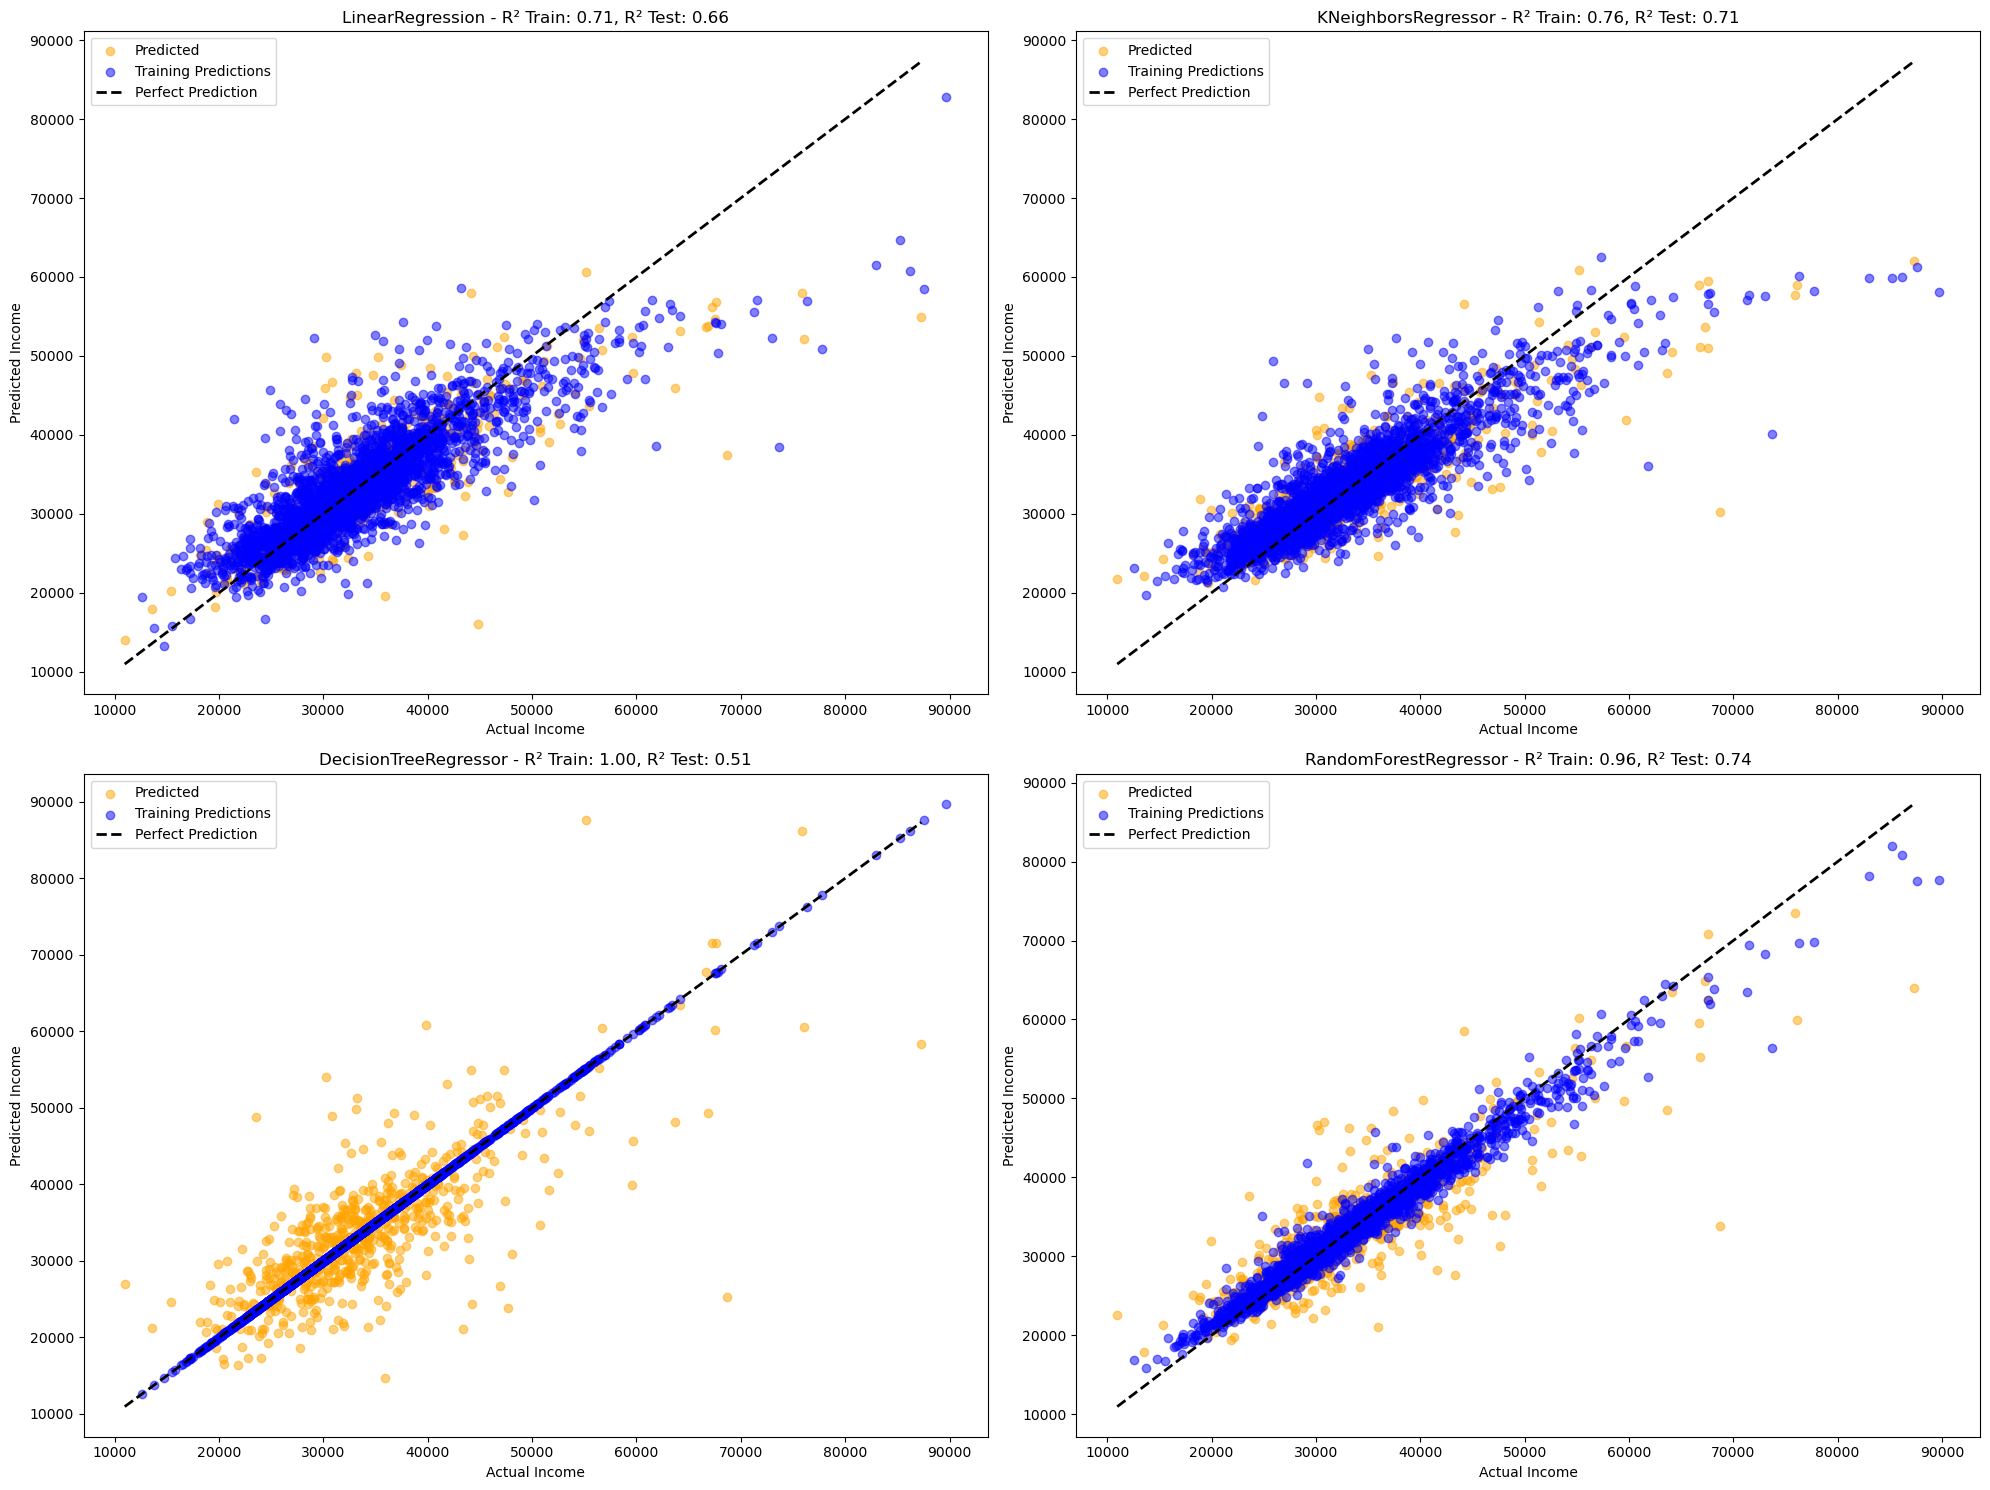

In [48]:
from sklearn.metrics import r2_score

plt.figure(figsize=(20, 15))

##loop through models 
for i, model in enumerate(model_list):

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    ##R^2 scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='Predicted', color='orange')
    plt.scatter(y_train, y_train_pred, alpha=0.5, label='Training Predictions', color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    
    plt.title(f"{model.__class__.__name__} - R² Train: {r2_train:.2f}, R² Test: {r2_test:.2f}")
    plt.xlabel('Actual Income')
    plt.ylabel('Predicted Income')
    plt.legend()

##show plots
plt.tight_layout()
plt.show()

## Part 1B: Multilayer Perceptron in Scikit-Learn

Now that we've prepared our data, run some classical (and still relevant) machine learning models on it (using out-of-the-box defaults with Scikit-Learn), now let's do some simple *Deep Learning* with a multilayer perceptron.  We will briefly build and train an MLP using Scikit-Learn.

Using the `MLPRegressor` class, specify an MLP with the following parameters:

- Three hidden layers all of size 64
- Use activation function ReLU
- Set `alpha = 0` for no regularization
- Set the model to run for at most 100 epochs (iterations), with a batch size of 64

**Once you've specified the model, fit to the (scaled) training data, and report the $R^2$ on both the training and testing datasets.**

In [116]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##MLP model
mlp = MLPRegressor(hidden_layer_sizes=(64, 64, 64), 
                   activation='relu', 
                   alpha=0, 
                   max_iter=100, 
                   batch_size=64, 
                   random_state=42)

mlp.fit(X_train_scaled, y_train)

##training data
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

##getting R^2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
##warning that max iterations were reached, I tried increasing the max iterations but left it at 100 for submission

C:\Users\Rbrig\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [117]:
print(f'R^2 score on training data: {r2_train:.4f}')
print(f'R^2 score on testing data: {r2_test:.4f}')

R^2 score on training data: 0.0024
R^2 score on testing data: -0.1356


## Part 2: Multilayer Perceptron for Classification


Now let's use Scikit-Learn to make a simple MLP for binary classification.

- Your job will be to use the `MLPClassifier` to classify hand-written digits as 5 or not-5 (i.e., any of the other 0,1,...,9).

- Having trained the classifier, you will need to report the confusion matrix, basic performance metrics, and generate ROC and Precision-Recall Curves

Run the following cell, **with appropriate modification**, to download the MNIST numbers dataset to a directory of your choice.

Run the cell after to load and convert the data to numpy arrays.

In [91]:
##get MNIST
from torchvision.datasets import MNIST

from torchvision.transforms import ToTensor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
##MLP model
mlp = MLPRegressor(hidden_layer_sizes=(64, 64, 64), 
                   activation='relu', 
                   alpha=0, 
                   max_iter=100, 
                   batch_size=64, 
                   random_state=42)

mlp.fit(X_train_scaled, y_train)

C:\Users\Rbrig\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0, batch_size=64, hidden_layer_sizes=(64, 64, 64),
             max_iter=100, random_state=42)

In [94]:
##training data
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

##getting R^2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'R^2 score on training data: {r2_train:.4f}')
print(f'R^2 score on testing data: {r2_test:.4f}')

mnist_trainset = MNIST(root='./', train=True, download=True, transform=ToTensor())

mnist_testset = MNIST(root='./', train=False, download=True, transform=ToTensor())

##warning that max iterations were reached, I tried increasing the max iterations but left it at 100 for submission

R^2 score on training data: 0.7469
R^2 score on testing data: 0.7002


In [65]:
#Run this cell to put the PyTorch DataSets into simple numpy:
#########

#Preallocate our training and testing numpy arrays:
#Note that our input data is the form of 28x28 digits
X_train = np.zeros([60000, 28, 28])
y_train = np.zeros([60000])

X_test = np.zeros([10000, 28, 28])
y_test = np.zeros([10000])

#Run these loops to build X_train, y_train:
for index, (i,j) in enumerate(mnist_trainset):
    X_train[index, :] = i.numpy()
    y_train[index] = j
    
#And X_test, y_test
for index, (i,j) in enumerate(mnist_testset):
    X_test[index, :] = i.numpy()
    y_test[index] = j

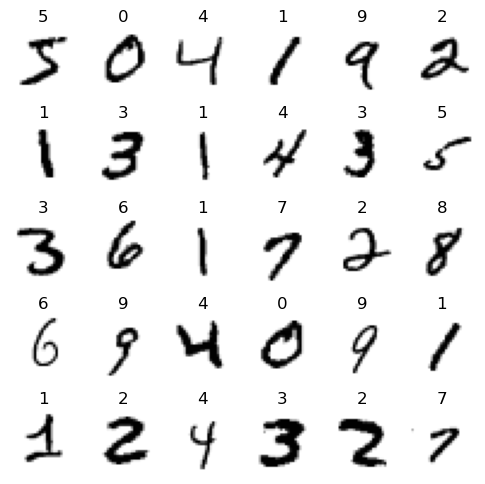

In [66]:
##Finally, run this to plot the first 30 digits, confirming everything went okay
########

fig1, ax1 = plt.subplots(5, 6, figsize=(6,6))

#Flatten for easier indexing
ax1 = ax1.flatten()

#And plot:
for i in range(30):

    #Plot
    im = ax1[i].imshow(X_train[i], cmap='gray_r')
    
    #Report number category
    ax1[i].set_title(int(y_train[i]), y=.925)
    ax1[i].set_axis_off()

## Binary Classification: 5 vs. Not-5

1. Construct new target variables:

- `y_train_5`: This should be equal to $0$ if the corresponding `y_train` value is not $5$, and $1$ otherwise
- `y_test_5`: Similar for the test dataset

2. Flatten the input arrays:

- Reshape your `X_train` and `X_test` arrays to shapes $60,000\times784$ and $10,000\times784$, respectively

3. Construct an `MLPClassifier` with the following structural parameters:

- Use three hidden layers, each of size 32
- Use a ReLU activation function
- Set `alpha = 0`, for no normalization
- Set the maximum number of epochs/iterations to 2, and the batch size to 256



In [97]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

In [98]:
##Load MNIST daata
mnist_trainset = MNIST(root='./', train=True, download=True, transform=ToTensor())
mnist_testset = MNIST(root='./', train=False, download=True, transform=ToTensor())

In [99]:
##convert to numpy arrays
X_train = mnist_trainset.data.numpy().reshape(-1, 28 * 28)
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy().reshape(-1, 28 * 28)
y_test = mnist_testset.targets.numpy()

y_train_5 = (y_train == 5).astype(int)
y_test_5 = (y_test == 5).astype(int)

In [100]:
##train MLP
mlp_classifier = MLPClassifier(hidden_layer_sizes=(32, 32, 32), 
                                activation='relu', 
                                alpha=0, 
                                max_iter=2, 
                                batch_size=256, 
                                random_state=42)

mlp_classifier.fit(X_train, y_train_5)

##training data
y_pred = mlp_classifier.predict(X_test)

##confusion Matrix
conf_matrix = confusion_matrix(y_test_5, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test_5, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[9052   56]
 [ 144  748]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9108
           1       0.93      0.84      0.88       892

    accuracy                           0.98     10000
   macro avg       0.96      0.92      0.94     10000
weighted avg       0.98      0.98      0.98     10000



C:\Users\Rbrig\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


### 5 vs. Not-5 Continued

**Now fit your model (using 2 epochs, as specified above), generate predictions on both the training and testing data, and report the following, for the *testing* dataset:**

1. Confusion Matrix
2. Accuracy
3. No information rate (NIR)
4. Sensitivity (Recall)
5. Positive Predictive Value (Precision)


In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [102]:
##predictions for data
y_train_pred = mlp_classifier.predict(X_train)
y_test_pred = mlp_classifier.predict(X_test)

In [103]:
##confusion matrix
conf_matrix = confusion_matrix(y_test_5, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9052   56]
 [ 144  748]]


In [104]:
##accuracy
accuracy = accuracy_score(y_test_5, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9800


In [105]:
##NIR
NIR = max(conf_matrix[0]) / sum(conf_matrix.sum(axis=1))
print(f"No Information Rate (NIR): {NIR:.4f}")

No Information Rate (NIR): 0.9052


In [106]:
##sensitivity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # True Positive / (True Positive + False Negative)
print(f"Sensitivity (Recall): {sensitivity:.4f}")

Sensitivity (Recall): 0.8386


In [107]:
##precision
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])  # True Positive / (True Positive + False Positive)
print(f"Positive Predictive Value (Precision): {precision:.4f}")

Positive Predictive Value (Precision): 0.9303


### ROC and Precision-Recall Curves

Generate ROC and Precision-Recall curves for your 5 vs. not-5 classifier for **both** the training and testing sets.

Your curves should resemble the following:

In [108]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [109]:
##ROC curve/area for training and testing set
y_train_scores = mlp_classifier.predict_proba(X_train)[:, 1]
y_test_scores = mlp_classifier.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train_5, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test_5, y_test_scores)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

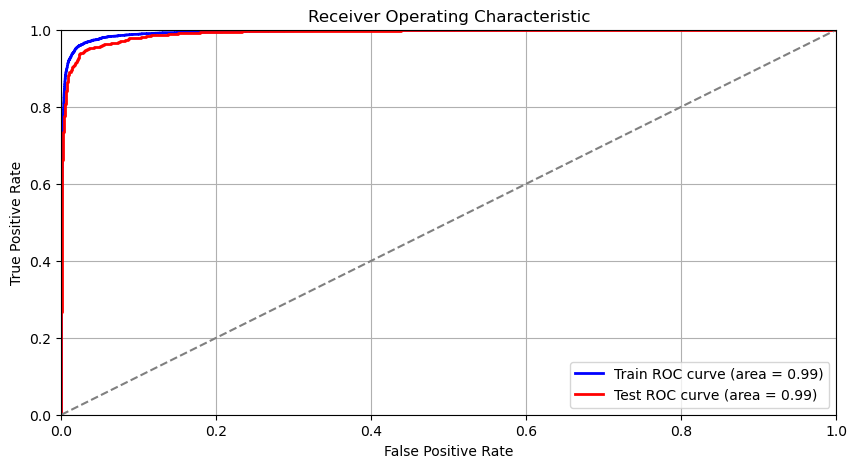

In [110]:
##plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Multi-Class Classification: All MNIST Number Classes

Now, train one more `MLPClassifier` model that is a multiclassifier. Model specification:

- Three hidden layers of size 64 each
- Maximum number of training iterations/epochs equal to 2
- batch size of 128
- `alpha = 0`

For this model, simply try to predict the digit category from the input.

**Report the overall accuracy and no-information rate.**

**Report the confusion matrix. Try to identify any trends in misclassifications. *For example, what number does the model most commonly misclassify 9s as?***

In [121]:
from sklearn.neural_network import MLPClassifier

##specifying the model
mlp_classifier_multiclass = MLPClassifier(hidden_layer_sizes=(64, 64, 64), max_iter=2, batch_size=128, alpha=0)

In [122]:
##training the model
mlp_classifier_multiclass.fit(X_train, y_train)
##warning that max iterations are reached

C:\Users\Rbrig\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0, batch_size=128, hidden_layer_sizes=(64, 64, 64),
              max_iter=2)

In [123]:
##predictions
y_train_pred_multiclass = mlp_classifier_multiclass.predict(X_train)
y_test_pred_multiclass = mlp_classifier_multiclass.predict(X_test)

In [ ]:
##accuracy
accuracy_multiclass = accuracy_score(y_test, y_test_pred_multiclass)
print(f"Overall Accuracy: {accuracy_multiclass:.4f}")

In [ ]:
##NIR
NIR_multiclass = max(np.bincount(y_test)) / len(y_test)
print(f"No Information Rate (NIR): {NIR_multiclass:.4f}")

In [125]:
##confusion matrix
conf_matrix_multiclass = confusion_matrix(y_test, y_test_pred_multiclass)
print("Confusion Matrix for Multi-Class:")
print(conf_matrix_multiclass)

Confusion Matrix for Multi-Class:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Part 3: Linear Regression: Cost Function and L2 Regularization

Recall our general linear regression model takes the form,

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_m x_m
$$

- $\hat{y}$ $=$ predicted values

- $m$ $=$ Number of features

- $x_i$ $=$ $i$th feature

- $\theta_j$ $=$ $j$th model parameter, where $\theta_0$ is also known as the bias term and $\theta_1, ..., \theta_m$ are the the feature weights

Thus, we often rewrite as

$$
\hat{y} = b + w_1 x_1 + w_2 x_2 + ... + w_m x_m
$$


#### Minimal Regression

Here, we will explore a *minimal* regression model, where we have a single input/feature, and we set the bias equal to $0$ (we construct the output to have mean $0$):

$$
\hat{y} = w_1 x
$$

We will explore this model using simple synthetic data: Run the following cell to generate some very simple synthetic data:
- `x` is the single feature (input)
- `y` is the output (target)

The data is generated using a linear model plus Gaussian noise. We will "manually" examine the error curve as a function of a single weight, with and without regularization.

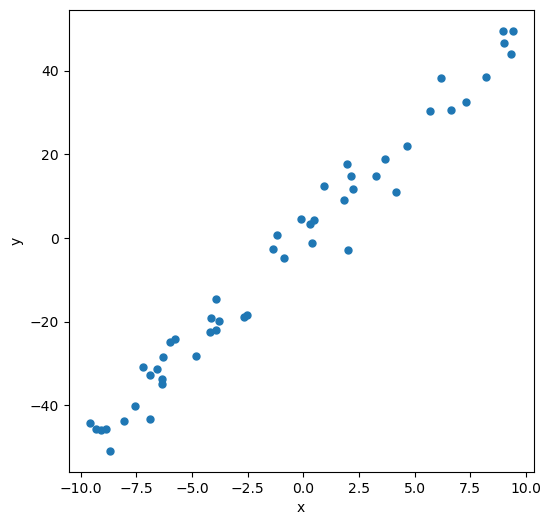

In [15]:
#Some synthetic data
N = 50

#Random points between -10 and 10, sorted:
np.random.seed(42)
x = np.random.uniform(-10, 10, N)
x.sort()

#Linear equation with noise:
y = 5*x + np.random.normal(loc=0, scale=5, size=N)

#Plot our data:
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot(x, y, 'o', markersize=5);

ax1.set_xlabel('x')
ax1.set_ylabel('y');

#### MSE Function

Write a function that calculates the **mean square error**, given two vectors (of equal-length):

```
def get_MSE(y_true, y_model):
    ...
    
    return MSE
```

In [13]:
def get_MSE(y_true, y_model):

    if len(y_true) != len(y_model):
        raise ValueError("Vectors must be of the same length.")
    
    squared_diffs = [(true - model) ** 2 for true, model in zip(y_true, y_model)]
    
    MSE = sum(squared_diffs) / len(squared_diffs)
    
    return MSE

#### Generate Prediction, MSE

Now, as mentioned, suppose you'd like to fit a linear regression model with a single parameter, $w_1$:

$$
\hat{y} = w_1 x 
$$

We assume here that the bias, $b$, is zero.

**Plot the MSE as a function of $w_1$, for a reasonable range of $w_1$ values.**  Your plot should look something like the following:

In [136]:
##sample data 
x = np.array([0, 1, 2, 3, 4, 5])
y_true = np.array([0, 1, 2, 3, 4, 5])

w1_values = np.linspace(-10, 10, 100)
mse_values = []

for w1 in w1_values:
    y_model = w1 * x
    mse = get_MSE(y_true, y_model)
    mse_values.append(mse)

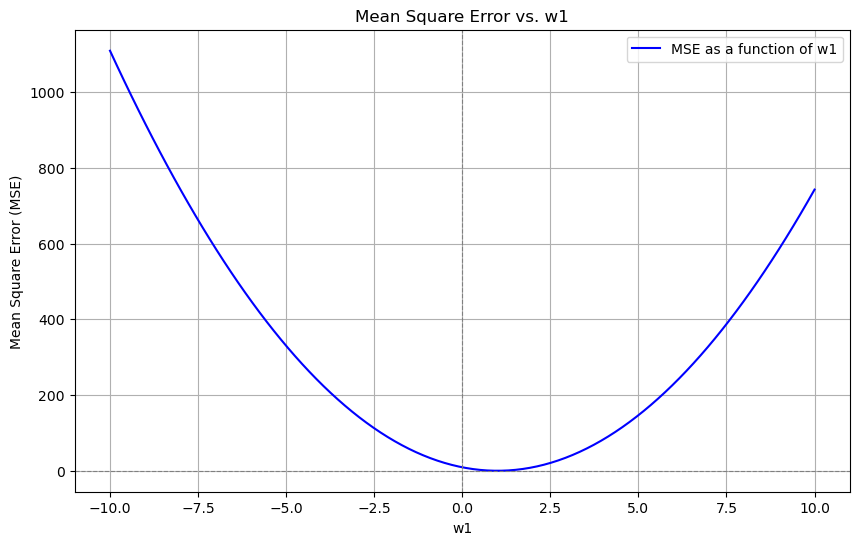

In [137]:
##plot MSE
plt.figure(figsize=(10, 6))
plt.plot(w1_values, mse_values, label='MSE as a function of w1', color='blue')
plt.title('Mean Square Error vs. w1')
plt.xlabel('w1')
plt.ylabel('Mean Square Error (MSE)')
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')
plt.grid()
plt.legend()
plt.show()

#### Add L2 Regularization

Recall the general form for L2 regularization:

$$
E(\mathbf{\theta}) = \text{MSE}(\mathbf{\theta}) + \frac{\lambda}{n} \sum_{i=1}^m \theta_i^2 = \frac{1}{n} \left(\sum_{i=1}^n \left( \hat{y}^{(i)} - y^{(i)} \right)^2 + \lambda \sum_{i=1}^m \theta_i^2 \right)
$$

Or, using weights, $w_i$, for our notation:

$$
E(\mathbf{w}, b) = \text{MSE}(\mathbf{\theta}) + \frac{\lambda}{n} \sum_{i=1}^m w_i^2 = \frac{1}{n} \left(\sum_{i=1}^n \left( \hat{y}^{(i)} - y^{(i)} \right)^2 + \lambda \sum_{i=1}^m w_i^2 \right)
$$


*Note that $b = \theta_0$, the bias term, is not regularized.* The regularization term represents the "length" (or norm) of our weight vector. The norm is the so-called L2 norm, and so this is also referred to as L2 regularization.


**Now, implement the addition of a regularization term to the cost function for our minimal regression**. Write a function that generates the following cost function:

$$
E(w_1) = MSE(w_1) + \frac{\lambda}{n} w_1^2.
$$

Note once again that we assume a single regression parameter, with a bias of zero for the model.

Have your function take the form:

```
def get_MSE_wReg(y_true, y_model, w, lambda1):
    ...
    
    return MSE
```


In [14]:
def get_MSE_wReg(y_true, y_model, w, lambda1):
    if len(y_true) != len(y_model):
        raise ValueError("Vectors must be of the same length.")
    
    squared_diffs = [(true - model) ** 2 for true, model in zip(y_true, y_model)]
    mse = sum(squared_diffs) / len(squared_diffs)
    
    return MSE

### Plot error curve for different $\lambda$

Plot your error curve for the following values of $\lambda$: $0, 100, 1000, 3000, 10000$. Your plot should resemble the following:

### Predictions

Now, generate predictions, $\hat{y}$, for all input $x$, using the optimum $w_1$ for each level of regularization. Plot these predictions along with the data, **and also report your $w_1$ values.** Your figure should resemble the following:

In [ ]:
## Fill in

## Part 4: Logistic Regression: Cost Function and L2 Regularization

Now let's generate some binary categorical data, using a logistic regression model as the underlying ground truth:

Recall that, while we could use MSE, a better cost function for logistic regression is the negative log-likelihood, equivalent to the (binary) cross-entropy:

$$
NLL  = -\sum_{i=1}^n \left(y^{(i)} \log{(\sigma(z^{(i)}))} + (1 - y^{(i)})\log{(1-\sigma(z^{(i)}))}\right),
$$
where $\sigma(z^{(i)})$ is the logit ($b + \mathbf{w}^T\mathbf{x}$) for observation $i$, or if we let $\hat{p}^(i)$ represent the model-predicted probability of being in class $1$, we can write:

$$
NLL  = -\sum_{i=1}^n \left(y^{(i)} \log{(\hat{p}^{(i)})} + (1 - y^{(i)})\log{(1-\hat{p}^{(i)})}\right),
$$

Under the likelihood interpretation, we are trying to maximize the likelihood for the joint distribution of bernoulli random variables. Using cross-entropy, we have a model-generated probability distribution that we'd like to match to the true distribution by minimizing the cross-entropy between the distributions.

Write a function that calculates binary cross-entropy (same as NLL), given the true value, and model probability:

```
def Get_BCE(y_true, p_model):
    ...
    
    return BCE
```

In [4]:
def Get_BCE(y_true, p_model):
    p_model = np.clip(p_model, 1e-15, 1 - 1e-15)
    
    BCE = -np.mean(y_true * np.log(p_model) + (1 - y_true) * np.log(1 - p_model))
    
    return BCE

#### Now, run the following to generate some binary data from an underlying logistic regression model:

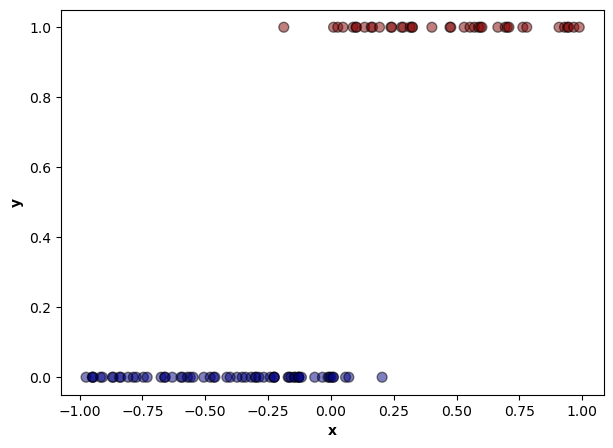

In [12]:
## Make our logits:

#Some synthetic data
N = 100

#Random points between -10 and 10, sorted:
np.random.seed(2)
x = np.random.uniform(-1, 1, N)
x.sort()


#Underlying logit:
y_logit = 10*x + np.random.normal(loc=0, scale=.1, size=N)

#Probability of being in particular class:
p = 1 / (1 + np.exp(-y_logit))

#Randomly determine class based on probabilities:
rand = np.random.uniform(0,1,N)
y = (rand < p).astype(np.float32)



#Plot our data:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))

ax1.scatter(x, y, c=y, s=50, cmap='jet', edgecolor='black', alpha=.5);

ax1.set_xlabel('x', fontweight='bold')
ax1.set_ylabel('y', fontweight='bold');

#### Finally, suppose we use the following logistic regression model:

$$
z = b + w_1 x, \, \text{but with } b=0
$$
$$
p = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

That is, we generate $z$ as simply a linear weighting of our input $x$, and then we estimate the probability that our output belongs to class $1$ as $p = \sigma(z)$.

Generate a curve of binary cross-entropy as a function of $w_1$, where $p$ (i.e., `p_model`), is determined according to the model above. It should resemble the following:

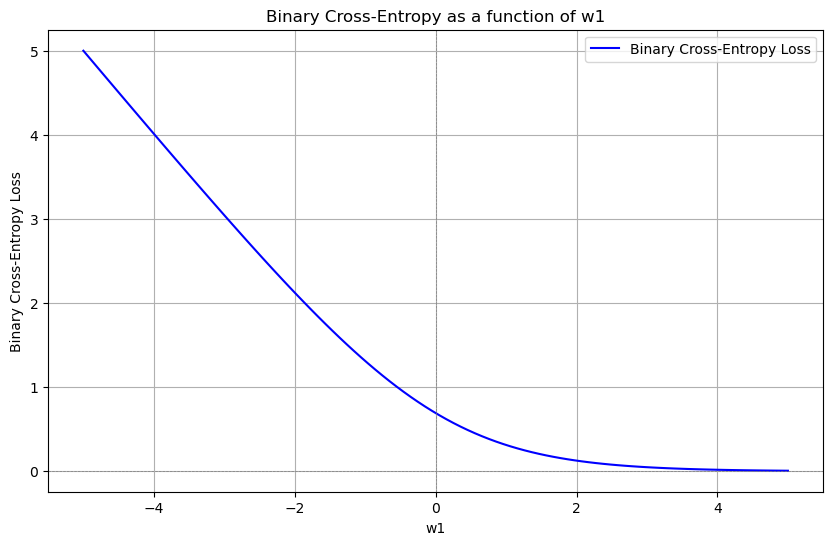

In [17]:
x = 1
w1_values = np.linspace(-5, 5, 100)
y_true = 1

losses = []
for w1 in w1_values:
    z = w1 * x
    p = 1 / (1 + np.exp(-z))
    loss = - (y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    losses.append(loss)

plt.figure(figsize=(10, 6))
plt.plot(w1_values, losses, label='Binary Cross-Entropy Loss', color='blue')
plt.title('Binary Cross-Entropy as a function of w1')
plt.xlabel('w1')
plt.ylabel('Binary Cross-Entropy Loss')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


### Add Regularization

Add L2 regularization to the negative log-likelihood cost function as follows:

$$
E(w_1) = NLL(w_1) + \frac{\lambda}{n} w_1^2
$$

Have your function take the form:

```
def get_MSE_wReg(y_true, y_model, w, lambda1):
    ...
    
    return MSE
```

Then, **plot the resulting cost as a function of $w_1$ for five levels of regularization: $\lambda = 0, 10, 25, 50, 100$.**

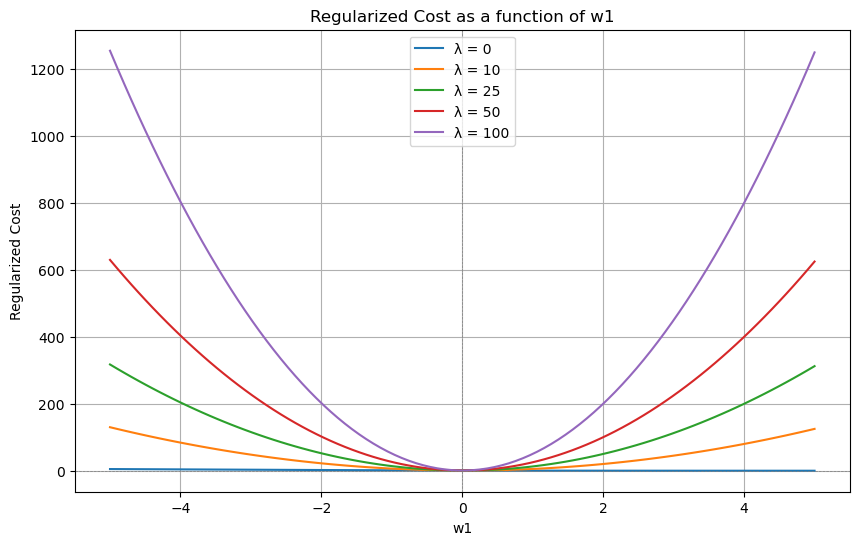

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def negative_log_likelihood(y_true, p):
    return - (y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def get_MSE_wReg(y_true, x, w1, lambda1):
    z = w1 * x
    p = sigmoid(z)
    nll = negative_log_likelihood(y_true, p)
    N = 1
    regularization = (lambda1 / 2) * (w1 ** 2)
    return nll + regularization

x = 1  
y_true = 1
w1_values = np.linspace(-5, 5, 100)
lambdas = [0, 10, 25, 50, 100]

plt.figure(figsize=(10, 6))

for lambda1 in lambdas:
    costs = []
    for w1 in w1_values:
        cost = get_MSE_wReg(y_true, x, w1, lambda1)
        costs.append(cost)
    plt.plot(w1_values, costs, label=f'λ = {lambda1}')

plt.title('Regularized Cost as a function of w1')
plt.xlabel('w1')
plt.ylabel('Regularized Cost')
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

#### Predictions

Finally, using the $w_1$ value that minimizes your cost function for each level of regularization, plot the predicted class $1$ probability across the range of the input (i.e., a continuous curve), $x$, along with the data. Your curves should resemble the following:



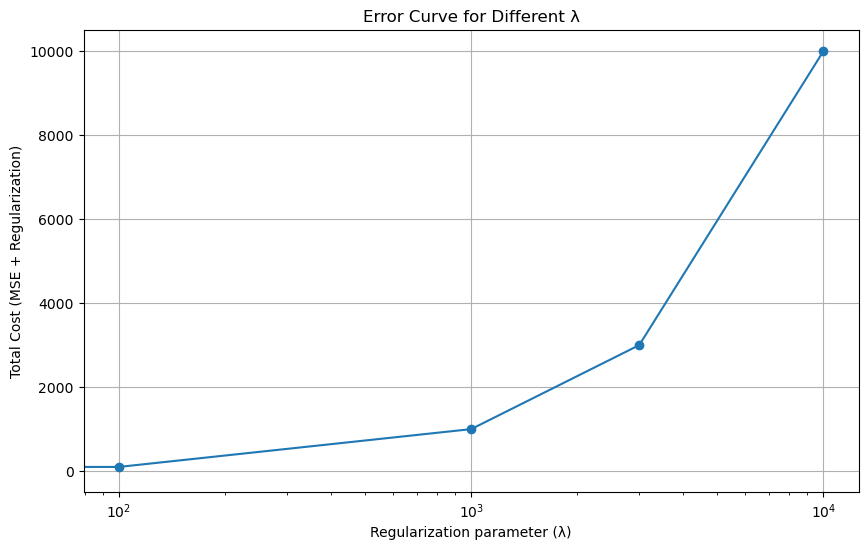

In [20]:
def get_MSE_wReg(y_true, y_model, w, lambda1):
    if len(y_true) != len(y_model):
        raise ValueError("Vectors must be of the same length.")
    
    squared_diffs = [(true - model) ** 2 for true, model in zip(y_true, y_model)]
    mse = sum(squared_diffs) / len(squared_diffs)
    
    regularization = lambda1 * (w ** 2)
    
    total_cost = mse + regularization
    
    return total_cost

y_true = np.array([3, -0.5, 2, 7])
y_model = np.array([2.5, 0.0, 2, 8])
w = 1.0  # Example weight
lambda_values = [0, 100, 1000, 3000, 10000]

costs = []
for lambda1 in lambda_values:
    cost = get_MSE_wReg(y_true, y_model, w, lambda1)
    costs.append(cost)

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, costs, marker='o')
plt.xscale('log')
plt.xlabel('Regularization parameter (λ)')
plt.ylabel('Total Cost (MSE + Regularization)')
plt.title('Error Curve for Different λ')
plt.grid(True)
plt.show()